# Problem statement

**Current Chatbot Landscape:**

- AI advancements have enabled sophisticated chatbot responses.
- However, many lack **updates** on rapidly evolving fields like climate transition.
- European environmental regulations are **rapidly changing**, posing an update challenge.
- Transformers, while powerful, can lose **track** of specific **references** during training.

**Objective**
- Develop a chatbot that references precise sources from pertinent **documents**, ensuring accuracy and credibility.


**Solution**
- Intergovernmental Panel on Climate Change (IPCC) is the UN body for climate change assessments.
- Integrate authoritative IPCC documents into the chatbot's knowledge base.
- Ensure the chatbot not only provides generic answers but also cites specific sources from the IPCC.

# Load Documents from a directory

- **Challenge**: Loading data from various PDFs can be cumbersome.
- **Solution**: Used PyPDFLoader from langchain.document_loaders to streamline the process.

In [6]:
import os
import time

In [7]:
%%time

from langchain.document_loaders import PyPDFLoader

def load_documents(directory_path):    
    pdf_files = [f for f in os.listdir(directory_path) if f.endswith('.pdf')]
    documents = []
    for pdf_file in pdf_files:
        pdf_path = os.path.join(directory_path, pdf_file)
        loader = PyPDFLoader(pdf_path)
        documents.extend(loader.load())
    return documents

CPU times: user 804 ms, sys: 1.26 s, total: 2.07 s
Wall time: 1.03 s


In [10]:
import tiktoken

def estimate_tokens(string, encoding_name="cl100k_base"):
    """Returns the number of tokens in a text string."""
    encoding_name = "cl100k_base"
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

def documents_info(directory_path):
    pdf_files = [f for f in os.listdir(directory_path) if f.endswith('.pdf')]
    documents_info = []
    
    for pdf_file in pdf_files:
        pdf_path = os.path.join(directory_path, pdf_file)
        loader = PyPDFLoader(pdf_path)
        
        # Document info
        doc_info = {}
        doc_info['file_name'] = pdf_file
        doc_info['number_of_pages'] = len(loader.load())
        doc_info['size_in_MB'] = os.path.getsize(pdf_path) / (1024 * 1024)  # Convert from bytes to MB
        
        # Estimate tokens
        tokens_per_page = [estimate_tokens(page.page_content, "cl100k_base") for page in loader.load()]
        doc_info['average_tokens_per_page'] = sum(tokens_per_page) / len(tokens_per_page)
        doc_info['total_tokens'] = sum(tokens_per_page)
        
        documents_info.append(doc_info)
        
    return documents_info

# Test
directory_path = "data/"
documents_info = documents_info(directory_path)
for doc in documents_info:
    print(f"File Name: {doc['file_name']}")
    print(f"Number of Pages: {doc['number_of_pages']}")
    print(f"Size (in MB): {doc['size_in_MB']:.2f}")
    print(f"Average Tokens per Page: {doc['average_tokens_per_page']:.2f}")
    print(f"Total Tokens: {doc['total_tokens']}")
    print("="*50)

File Name: IPCC_AR6_WGII_SummaryForPolicymakers.pdf
Number of Pages: 34
Size (in MB): 1.33
Average Tokens per Page: 1196.44
Total Tokens: 40679
File Name: IPCC_AR6_WGI_SPM.pdf
Number of Pages: 32
Size (in MB): 3.21
Average Tokens per Page: 1033.06
Total Tokens: 33058
File Name: IPCC_AR6_WGIII_SummaryForPolicymakers.pdf
Number of Pages: 51
Size (in MB): 1.12
Average Tokens per Page: 1098.41
Total Tokens: 56019


# Pre-process the data

- **Challenge**: Raw text data may contain unwanted characters or inconsistent formatting.
- **Opportunity**: cost and time saving by removing unwanted characters
- **Solution**: Utilized regular expressions and string manipulations to clean the data.

In [15]:
documents = load_documents(directory_path)

In [17]:
documents[10].page_content

'11SPM\nSummary for Policymakers\nB.1.4 Climate change has adversely affected physical health of people globally (very high confidence) and mental health of people in the \nassessed regions (very high confidence). Climate change impacts on health are mediated through natural and human systems, including \neconomic and social conditions and disruptions (high confidence). In all regions extreme heat events have resulted in human mortality \nand morbidity (very high confidence). The occurrence of climate-related food-borne and water-borne diseases has increased (very high \nconfidence). The incidence of vector-borne diseases has increased from range expansion and/or increased reproduction of disease vectors \n(high confidence). Animal and human diseases, including zoonoses, are emerging in new areas (high confidence). Water and food-borne \ndisease risks have increased regionally from climate-sensitive aquatic pathogens, including Vibrio spp. ( high confidence), and from toxic \nsubstance

In [14]:
import re

def preprocess_content(text):
    text = text.replace('\xa0', ' ')
    text = text.replace('\n', ' ')
    text = re.sub(' +', ' ', text)
    text = re.sub(r'(?<=[a-z])([A-Z][a-z]+)', r'\n\1', text)
    text = re.sub(r'\d+TS', '', text)
    text = re.sub(r'\{\d+(\.\d+)?\}', '', text)
    text = re.sub(r'\{.*?\}', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

# Test
doc_content = documents[10]
preprocessed_content = preprocess_content(documents[10].page_content)
print(preprocessed_content)

11SPM Summary for Policymakers B.1.4 Climate change has adversely affected physical health of people globally (very high confidence) and mental health of people in the assessed regions (very high confidence). Climate change impacts on health are mediated through natural and human systems, including economic and social conditions and disruptions (high confidence). In all regions extreme heat events have resulted in human mortality and morbidity (very high confidence). The occurrence of climate-related food-borne and water-borne diseases has increased (very high confidence). The incidence of vector-borne diseases has increased from range expansion and/or increased reproduction of disease vectors (high confidence). Animal and human diseases, including zoonoses, are emerging in new areas (high confidence). Water and food-borne disease risks have increased regionally from climate-sensitive aquatic pathogens, including Vibrio spp. ( high confidence), and from toxic substances from harmful fr

In [20]:
old_tokens_count = 129756
new_tokens_count = 0

for doc in documents:
    doc.page_content=preprocess_content(doc.page_content)
    new_tokens_count += estimate_tokens(doc.page_content)

In [21]:
new_tokens_count

102189

# Create an enriched version of the Class

- **Challenge**: Document Class: Basic representation of a document with page content and metadata.
- **Solution**:EnrichedDocument Class: Extends the Document class to provide a more detailed structure.

In [28]:
# We will add some metadata to class Document
class Document:
    def __init__(self, page_content, metadata):
        self.page_content = page_content
        self.metadata = metadata

class EnrichedDocument(Document):
    def __init__(self, page_content, metadata):
        super().__init__(page_content, metadata)

# Split Documents into Smaller chunks

- SentenceTransformersTokenTextSplitter: Split documents into manageable chunks for processing.
- **Challenge**:
  - Large documents need to be divided into smaller sections
  - The consolidated chunks after similarity search need to fit in the window context of the token limit of the chatbot
- **Solution**: Used SentenceTransformersTokenTextSplitter with an overlap to ensure no data is lost between chunks.

In [35]:
import tiktoken

def estimate_tokens(string, encoding_name):
    """Returns the number of tokens in a text string."""
    encoding_name = "cl100k_base"
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

#----split docs into chunks----
def split_documents_into_chunks(documents, text_splitter):
    
    all_enriched_documents = []
    global_page_number = 0
    chunk_id = 0
    
    for doc in documents:
        chunks = text_splitter.split_text(doc.page_content)
        for chunk in chunks:
            char_count = len(chunk)
            token_count = estimate_tokens(chunk,"cl100k_base")
            chunk_content=preprocess_content(chunk)
            enriched_metadata = {
                'source': doc.metadata['source'],
                'path': doc.metadata.get('path', ''),
                'page': doc.metadata['page'],
                'char_count': char_count,
                'token_count': token_count,
                'global_page_number': global_page_number,
                'chunk_id': chunk_id,
                'chunk_content':chunk_content
            }
            enriched_doc = EnrichedDocument(chunk, enriched_metadata)
            all_enriched_documents.append(enriched_doc)
            chunk_id += 1
        
        global_page_number += 1  # Increment the global page number for each document  
    
    return all_enriched_documents

In [38]:
from langchain.text_splitter import SentenceTransformersTokenTextSplitter

text_splitter = SentenceTransformersTokenTextSplitter(tokens_per_chunk=384, chunk_overlap=40)
chunks = split_documents_into_chunks(documents, text_splitter)
len(chunks)

352

In [39]:
chunks[150].page_content

'19spm summary for policymakerswas exceeded on average once in a decade during the 1850 – 1900 reference period. agricultural and ecological drought events are defined as the annual average of total column soil moisture below the 10th percentile of the 1850 – 1900 base period. these extremes are defined on model grid box scale. for hot temperature extremes and extreme precipitation, results are shown for the global land. for agricultural and ecological drought, results are shown for drying regions only, which correspond to the ar6 regions in which there is at least medium confidence in a projected increase in agricultural and ecological droughts at the 2°c warming level compared to the 1850 – 1900 base period in the coupled model intercomparison project phase 6 ( cmip6 ). these regions include western north america, central north america, northern central america, southern central america, caribbean, northern south america, north - eastern south america, south american monsoon, south -

In [40]:
len(chunks)

352

In [42]:
chunks[150].metadata

{'source': 'data/IPCC_AR6_WGI_SPM.pdf',
 'path': '',
 'page': 18,
 'char_count': 2021,
 'token_count': 404,
 'global_page_number': 52,
 'chunk_id': 150,
 'chunk_content': '19spm summary for policymakerswas exceeded on average once in a decade during the 1850 – 1900 reference period. agricultural and ecological drought events are defined as the annual average of total column soil moisture below the 10th percentile of the 1850 – 1900 base period. these extremes are defined on model grid box scale. for hot temperature extremes and extreme precipitation, results are shown for the global land. for agricultural and ecological drought, results are shown for drying regions only, which correspond to the ar6 regions in which there is at least medium confidence in a projected increase in agricultural and ecological droughts at the 2°c warming level compared to the 1850 – 1900 base period in the coupled model intercomparison project phase 6 ( cmip6 ). these regions include western north america, c

# Create a dataframe out of the enriched documents

For a better **visualization** of token distribution

In [44]:
import pandas as pd

def enriched_docs_to_dataframe(enriched_documents):
    # Extract the content and metadata into separate lists
    contents = [doc.page_content for doc in enriched_documents]
    metadata_list = [doc.metadata for doc in enriched_documents]
    
    # Convert metadata list to DataFrame
    df = pd.DataFrame(metadata_list)
    
    # Add content to DataFrame
    df['page_content'] = contents
    
    return df

# Usage:
df_enriched_docs = enriched_docs_to_dataframe(chunks)
df_enriched_docs.head()  # Print the first few rows of the DataFrame


,source,path,page,char_count,token_count,global_page_number,chunk_id,chunk_content,page_content
0,data/IPCC_AR6_WGII_SummaryForPolicymakers.pdf,,0,24,3,0,0,summary for policymakers,summary for policymakers
1,data/IPCC_AR6_WGII_SummaryForPolicymakers.pdf,,2,1409,397,2,1,spm3 summary for policymakers drafting authors...,spm3 summary for policymakers drafting authors...
2,data/IPCC_AR6_WGII_SummaryForPolicymakers.pdf,,2,1392,402,2,2,"##a loeschke ( germany ), simone lucatello ( m...","##a loeschke ( germany ), simone lucatello ( m..."
3,data/IPCC_AR6_WGII_SummaryForPolicymakers.pdf,,2,1255,392,2,3,"yanda ( tanzania ), zelina zaiton ibrahim ( ma...","yanda ( tanzania ), zelina zaiton ibrahim ( ma..."
4,data/IPCC_AR6_WGII_SummaryForPolicymakers.pdf,,2,87,40,2,4,", cambridge, uk and new york, ny, usa, pp. 3 –...",", cambridge, uk and new york, ny, usa, pp. 3 –..."


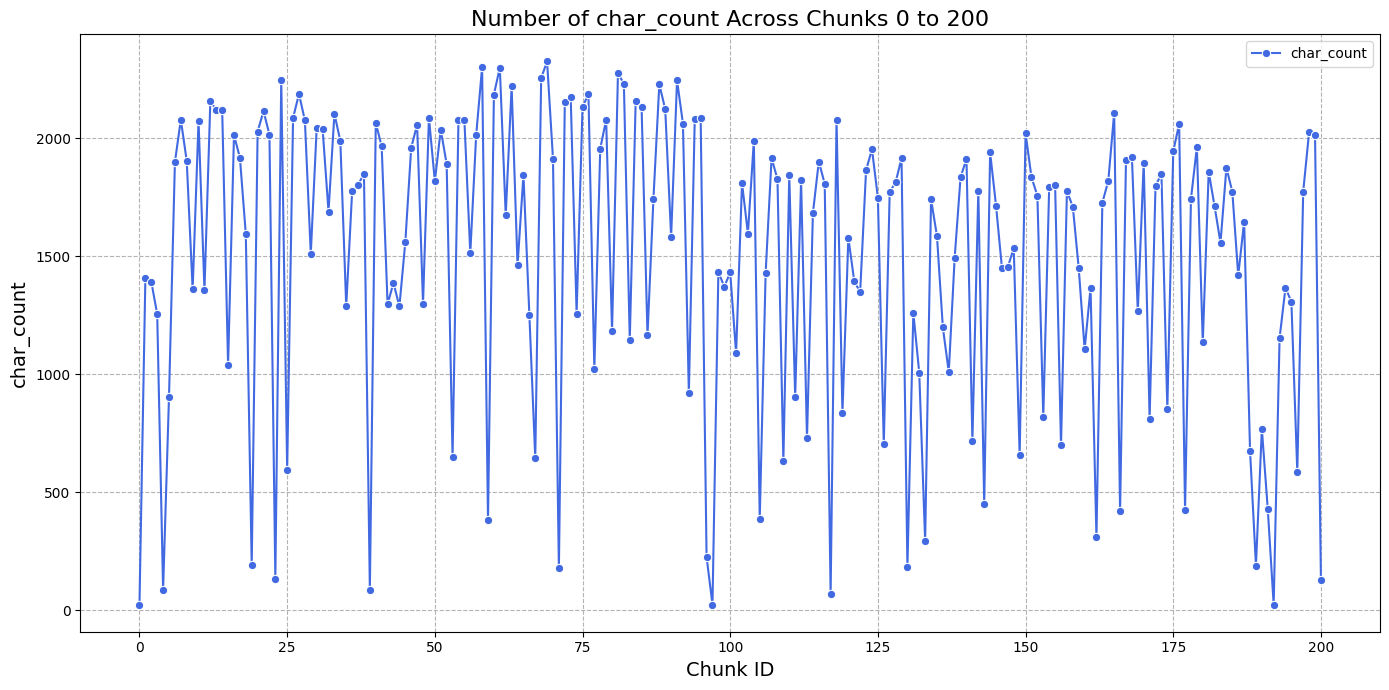

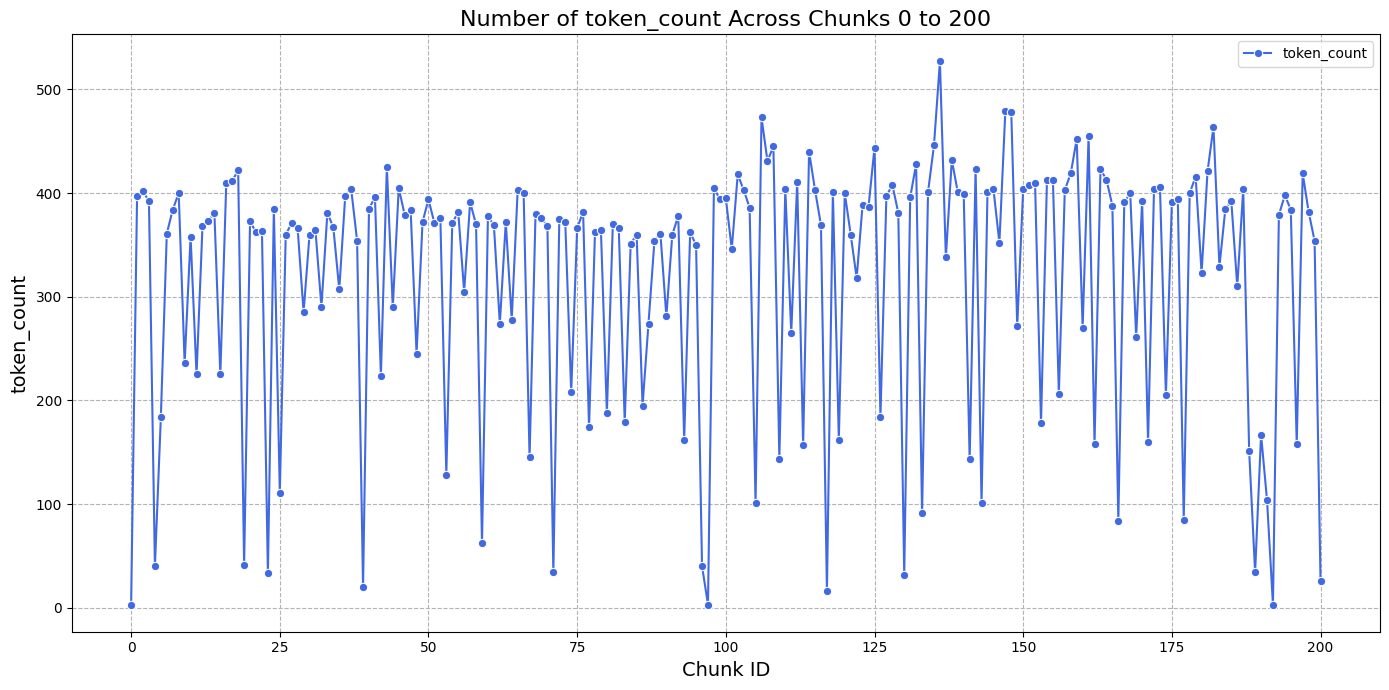

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_across_chunks(df, column_name, start_chunk=0, end_chunk=200):

    # Filter the dataframe to only include the specified range of chunks
    df_filtered = df[(df['chunk_id'] >= start_chunk) & (df['chunk_id'] <= end_chunk)]
    
    # Setting up the figure and axis
    plt.figure(figsize=(14, 7))
    
    # Plotting number of characters across chunks
    sns.lineplot(data=df_filtered, x='chunk_id', y=str(column_name), marker="o", color='royalblue', label=column_name)
    
    # Beautifying the plot
    plt.title(f'Number of {column_name} Across Chunks {start_chunk} to {end_chunk}', fontsize=16)
    plt.xlabel('Chunk ID', fontsize=14)
    plt.ylabel(column_name, fontsize=14)
    plt.legend()
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.tight_layout()

    # Display the plot
    plt.show()

# Usage:
plot_across_chunks(df_enriched_docs, 'char_count', start_chunk=0, end_chunk=200)
plot_across_chunks(df_enriched_docs, 'token_count', start_chunk=0, end_chunk=200)

## Distribution of char count and token count

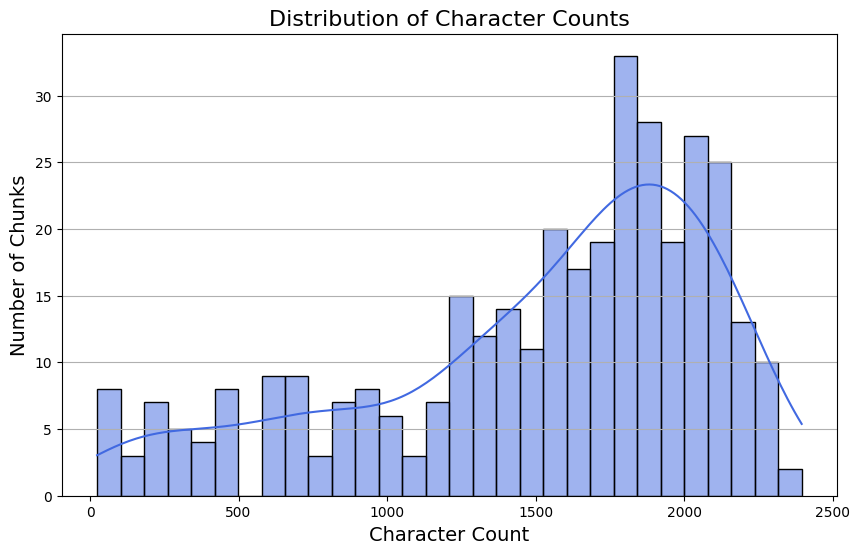

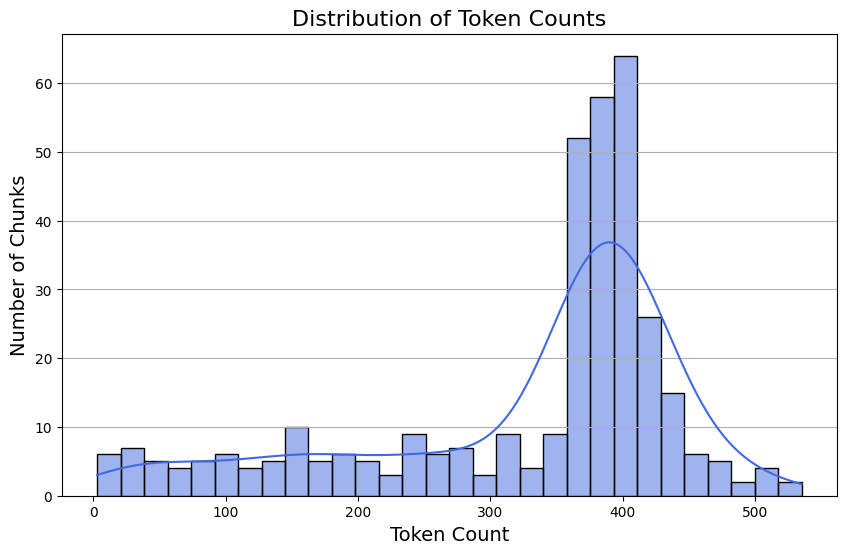

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(df_enriched_docs['char_count'], bins=30, color='royalblue', kde=True)
plt.title('Distribution of Character Counts', fontsize=16)
plt.xlabel('Character Count', fontsize=14)
plt.ylabel('Number of Chunks', fontsize=14)
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_enriched_docs['token_count'], bins=30, color='royalblue', kde=True)
plt.title('Distribution of Token Counts', fontsize=16)
plt.xlabel('Token Count', fontsize=14)
plt.ylabel('Number of Chunks', fontsize=14)
plt.grid(axis='y')
plt.show()

**Challenge**: Need a way to represent text data numerically in order to facilitate contextual search.

**Solution**: Choice of OpenAIEmbeddings for its performance and compatibility with our project.

## Compute Embeddings on all chunks

In [52]:
%%time

import openai

def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

df=df_enriched_docs.loc[:10,].copy()

df['ada_embedding'] = df['page_content'].apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))
df.to_csv('output/embedded_chunks.csv', index=False)

CPU times: user 142 ms, sys: 192 ms, total: 334 ms
Wall time: 5.26 s


**Challenge** : Storing embeddings in a dataframe is not the appropriate method for:
- super time consuming
- huge storage needed on the cpu (an embedding is 1536 dimensions)
- search would be difficult
- we need hashing and quantization techniques
- not a scalable approach

**Solution** Using vectorstores or indexes
- Vectorstores are tailor-made for this use case and we are better off using them to store the data
- **Indexing Strategies**: These systems offer a variety of indexing strategies tailored to different types of datasets and search requirements. This flexibility allows users to choose an indexing strategy that is best suited to their specific needs.
- **Efficient Storage**: These systems are optimized for storing large arrays of fixed-size vectors. They often use techniques like quantization to reduce the memory footprint of each vector, allowing for the storage of billions of vectors in memory.


# Create a vectorstore

In [53]:
%%time

from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS

embeddings=OpenAIEmbeddings(openai_api_key=os.getenv("OPENAI_API_KEY"))
vectorstore=FAISS.from_documents(chunks, embeddings)

CPU times: user 460 ms, sys: 381 ms, total: 841 ms
Wall time: 7.73 s


**Challenge**: Define a search strategy.

**Solution**: Import cosine similarity distance in high-dimensional space to find the most relevant chunks given a query
- Thanks to the vectorstore implementation, the vectors are quantizied making them **less heavy** and easier to **compare**

**Trade-offs** between accuracy (in terms of retrieving the most similar items) and speed.
FAISS aims to provide the best trade-offs between **accuracy** (in terms of retrieving the most similar items) and **speed**. Some of the techniques I mentioned earlier, like Product Quantization, Hierarchical Quantization, and others, are commonly used in state-of-the-art systems.

# Create a search Function

In [54]:
def nearest_neighbors(query, k=5):
    results = vectorstore.similarity_search_with_score(query="climate", k=k)
    return results

query = "risks of climate change"
results = nearest_neighbors(query, k=6)

In [55]:
def prettify(results):
    global_output=""
    for result in results:
        output = f"Source: {result[0].metadata['source']}\n"
        output += f"Page: {result[0].metadata['page']}\n"
        output += f"Score: {result[1]}\n"
        output += f"Chunk ID: {result[0].metadata['chunk_id']}\n\n"
        output += "Content:\n"
        output += str({result[0].page_content})
        output += "\n"
        output += "=" * 80
        output += "\n"
        global_output += output
    return global_output

print(prettify(results))

Source: data/IPCC_AR6_WGII_SummaryForPolicymakers.pdf
Page: 4
Score: 0.3424447774887085
Chunk ID: 8

Content:
{'the context of strengthening the global response to the threat of climate change, sustainable development, and efforts to eradicate poverty ( sr1. 5 ) ’ ; ‘ climate change and land. an ipcc special report on climate change, desertification, land degradation, sustainable land management, food security, and greenhouse gas fluxes in terrestrial ecosystems ( srccl ) ’ ; ‘ ipcc special report on the ocean and cryosphere in a changing climate ( srocc ) ’. 3 biodiversity : biodiversity or biological diversity means the variability among living organisms from all sources including, among other things, terrestrial, marine and other aquatic ecosystems, and the ecological complexes of which they are part ; this includes diversity within species, between species, and of ecosystems. 4 each finding is grounded in an evaluation of underlying evidence and agreement. a level of confidence is 

# Prompt engineering

In [56]:
def system_prompt(results):
    prompt = "Hi there, climate chatbot! Provide an answer citing the SOURCE AND PAGE. If the answer is still not available, reply with your own knowledge."
    context = prettify(results)
    return prompt + "\n" + context

# Time and Cost Monitoring

## Cost description from open ai developers api

In [68]:
grid

,MODEL,Usage,Window Context,Input Usage,Output Usage
0,GPT-4,Chat Completion,8K context,$0.03 / 1K tokens,$0.06 / 1K tokens
1,GPT-4,Chat Completion,32K context,$0.06 / 1K tokens,$0.12 / 1K tokens
2,GPT-3.5 Turbo,Chat Completion,4K context,$0.0015 / 1K tokens,$0.002 / 1K tokens
3,GPT-3.5 Turbo,Chat Completion,16K context,$0.003 / 1K tokens,$0.004 / 1K tokens
4,Ada v2,Embedding,unlimited,$0.0001 / 1K tokens,-


## Define a cost monitoring function for api calls

In [95]:
def openai_api_calculate_cost(usage, model):
    pricing = {
        'gpt-3.5-turbo': {
            'prompt': 0.0015,
            'completion': 0.002,
        },
        'gpt-3.5-turbo-4k': {
            'prompt': 0.0015,
            'completion': 0.002,
        },
        'gpt-3.5-turbo-16k': {
            'prompt': 0.003,
            'completion': 0.004,
        },
        'gpt-4': {
            'prompt': 0.03,
            'completion': 0.06,
        },
        'gpt-4-8k': {
            'prompt': 0.03,
            'completion': 0.06,
        },
        'gpt-4-32k': {
            'prompt': 0.06,
            'completion': 0.12,
        },
        'text-embedding-ada-002-v2': {
            'prompt': 0.0001,
            'completion': 0.0001,
        }
    }

    try:
        model_pricing = pricing[model]
    except KeyError:
        raise ValueError("Invalid model specified")

    prompt_cost = usage['prompt_tokens'] * model_pricing['prompt'] / 1000
    completion_cost = usage['completion_tokens'] * model_pricing['completion'] / 1000

    total_cost = prompt_cost + completion_cost
    
    return total_cost

# Chatbot Creation

In [59]:
%%time
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)
from langchain.chat_models import ChatOpenAI

CPU times: user 25.4 ms, sys: 42 ms, total: 67.4 ms
Wall time: 18.8 s


In [151]:
# candidate models: gpt-3.5-turbo-4k; gpt-4-8k'
model35 = "gpt-3.5-turbo"
model40 = "gpt-4"

def chatbot(query, model, k):
    # Global time monitoring --- start
    start_time = time.time()    
    
    # Chat Instanciation
    chat = ChatOpenAI(model=model, temperature=0, max_tokens=400)
    
    # Searching for nearest neighbors using the vectorstore cosine similarity
    start_time_kn = time.time()
    #--------------------------
    neighbors = nearest_neighbors(query, k=k)
    #--------------------------
    end_time_kn = time.time()
    duration_kn = end_time_kn - start_time_kn
    #--------------------------
    
    # Creating the prompt
    global_context = system_prompt(neighbors)
    messages = [SystemMessage(content=global_context), HumanMessage(content=query)]
    
    # api_call 
    start_time_api = time.time()
    #--------------------------
    response = chat(messages).content
    #--------------------------
    end_time_api = time.time()
    duration_api = end_time_api - start_time_api
    #--------------------------
    
    
    # cost api ($) monitoring
    usage={
        'prompt_tokens': estimate_tokens(global_context + " " + query),
        'completion_tokens': estimate_tokens(response)
    }
    global_cost = openai_api_calculate_cost(usage, model)
    
    #------ time end
    end_time = time.time()
    duration = end_time - start_time
    #------ time end
    
    return {'model': model,
            'global_cost': global_cost, 
            'duration_kn': duration_kn,
            'duration_api': duration_api,
            'duration': duration, 
            'response': response}

In [86]:
import pprint

def prettify_dict(data_dict):
    pp = pprint.PrettyPrinter(indent=4)
    pp.pprint(data_dict)

### Testing with gpt3.5 Turbo

In [89]:
query = "Give me some implications that are expected from the combination of future urban development and more frequent occurrence of extreme climate events"
response = chatbot(query, model35, k=3)
prettify_dict(response)

{   'duration': 9.82027816772461,
    'duration_api': 9.225726127624512,
    'duration_kn': 0.5665490627288818,
    'global_cost': 0.003831,
    'model': 'gpt-3.5-turbo',
    'response': 'The combination of future urban development and more frequent '
                'occurrence of extreme climate events is expected to have '
                'several implications. Here are some of them:\n'
                '\n'
                '1. Increased vulnerability of urban populations: Urban areas '
                'are likely to experience higher exposure to extreme climate '
                'events such as heatwaves, floods, and storms. This can lead '
                'to increased risks to human health, infrastructure, and '
                'livelihoods.\n'
                '\n'
                '2. Infrastructure challenges: Urban areas may face challenges '
                'in adapting their infrastructure to cope with more frequent '
                'and intense climate events. This includes 

### Testing with gpt4.0

In [96]:
query = "Give me some implications that are expected from the combination of future urban development and more frequent occurrence of extreme climate events"
response = chatbot(query, "gpt-4", k=3)
prettify_dict(response)

{   'duration': 13.251922845840454,
    'duration_api': 12.680819034576416,
    'duration_kn': 0.5487639904022217,
    'global_cost': 0.07164000000000001,
    'model': 'gpt-4',
    'response': 'The combination of future urban development and more frequent '
                'occurrence of extreme climate events is expected to increase '
                'vulnerability and risks. Key infrastructure systems including '
                'sanitation, water, health, transport, communications, and '
                'energy will be increasingly vulnerable if design standards do '
                'not account for changing climate conditions. Future exposure '
                'to climatic hazards is also increasing globally due to '
                'socioeconomic development trends including migration, growing '
                'inequality, and urbanization. Near-term warming and increased '
                'frequency, severity, and duration of extreme events will '
                'place many ter

-----------------
**Challenge** 
- In terms of time, both models are comparable.
- In terms of cost, gpt4 is 10x higher
- We can not **trade-off** before we **quantify** the **quality** of the response

---------------
My **approach**:
- I suggest comparing the model output (response) to some **ideal** outputs
- We will then quantify the distance of model35 to the ideal output and well as model40 to the ideal output
- The closer the output is to the **document passage**, the higher the quality of the answer is
- Assumption: in order for this test to be meaningful, we need to generate questions that **come actually** from the documents


## Monitoring - part 2: Questions/Answers generator

In [122]:
documents[1]

'Document 2 content here'

In [115]:
def generate_10qa_from_doc(doc):   
    chat = ChatOpenAI(model='gpt-4')
    context = doc.page_content
    query = "Given this document, can you generate 10 questions with their corresponding ideal answers? Always start by: Question: ... then Answer: ..."
    
    messages = [
        SystemMessage(content=context), 
        HumanMessage(content=query)
        ]
    
    response = chat(messages).content
    
    # Extract questions and answers from the response
    qa_list = []
    split_response = response.split("Question:")
    for item in split_response[1:]:  # Skip the first item as it's before the first "Question:"
        question_answer_split = item.split("Answer:")
        question = question_answer_split[0].strip()
        answer = question_answer_split[1].split("Question:")[0].strip()  # In case there's another "Question:" after
        qa_list.append({'question': question, 'answer': answer})
    
    return qa_list


pairs=generate_10qa_from_doc(documents[10])

[{'question': 'How has climate change affected the physical and mental health of people worldwide?',
  'answer': 'Climate change has negatively impacted both the physical and mental health of people around the world. This includes increases in human mortality and morbidity due to extreme heat events, increased occurrence of climate-related food and water-borne diseases, and emerging diseases in new areas. Mental health challenges have been associated with increasing temperatures, trauma from extreme weather events, and loss of livelihoods and culture.'},
 {'question': "What role do natural and human systems play in mediating climate change's impact on health?",
  'answer': 'Natural and human systems, including economic and social conditions and disruptions, mediate the impacts of climate change on health. These systems influence the exposure and vulnerability of populations to climate-related risks.'},
 {'question': 'How has climate change affected urban settings?',
  'answer': 'In urb

In [ ]:
%%time
from openai.embeddings_utils import get_embedding, cosine_similarity

def generate_dataframe(pairs):
    model_emb = 'text-embedding-ada-002'
    data = []
    for pair in pairs[:1]:        
        query = pair['question']
        ideal_a = pair['answer']
        
        # Extracting the model responses and metadata
        model35_data = chatbot(query, 'gpt-3.5-turbo', 2)
        model35_response = model35_data['response']
        model35_duration = model35_data['duration']
        model35_cost = model35_data['global_cost']

        #model40_data = chatbot(query, 'gpt-4', 2)
        #model40_response = model40_data['response']
        #model40_duration = model40_data['duration']
        #model40_cost = model40_data['global_cost']
        
        # Computing embeddings
        embaa = get_embedding(ideal_a, model=model_emb)
        emb35 = get_embedding(model35_response, model=model_emb)
        #emb40 = get_embedding(model40_response, model=model_emb)
        
        # Computing scores 
        model35_score = cosine_similarity(embaa, emb35)
        model40_score = cosine_similarity(embaa, emb40)

        # Appending to the data list
        data.append({
            'question': query,
            'ideal_answer': ideal_a,
        #    'model35_answer': model35_response,
        #    'model40_answer': model40_response,
            'model35_score': model35_score,
            'model40_score': model40_score,
            'model35_duration': model35_duration,
       #     'model40_duration': model40_duration,
            'model35_cost': model35_cost,
        #    'model40_cost': model40_cost
        })

    return data
    
# Run
df = generate_dataframe(pairs)
df.head()

---------
**Conclusion**:

- **gpt35** seems to be a better solution in terms of quality / time and quality / price


**Next steps**
- Finetune on **k**
- Increase the test size to **10000**
- Try other quality metrics:
  - accuracy on more open questions (vs closed question from docs)
  - ability to avoid hallucations
  - distance as sum of distances between neighbors and ideal answer
- Try other vectorstores for speed comparison
- Try other LLMs (open-source) like mistral, falcon etc.

# Push to Gradio

In [149]:
import gradio as gr

def model_function(input_text):
    return chatbot(input_text, model35, k=5)

interface = gr.Interface(
    fn=model_function, 
    inputs="text", 
    outputs="text"
)

# Results

In [150]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Running on public URL: https://df38efb758d04d7be7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Future Work and Improvements


- Expand the Document Collection: As more data becomes available, the chatbot can be enhanced by adding more documents to its database.

- Fine-tuning the Model: The chatbot's performance can potentially be improved by fine-tuning the model on domain-specific data.